# Exercise 6: Analysis of real data  (score 30 points)


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from imageio import imread
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import seaborn as sns
import os
from common import *
import cv2
from sklearn.model_selection import cross_val_score
from sklearn import linear_model as sk
#from mpl_toolkits.mplot3d import Axes3D
#from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn import linear_model as lm

from sklearn.preprocessing import MinMaxScaler
from typing import Tuple


print(f"Root directory: {os.getcwd()}")

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "font.size": 10,
})

#%matplotlib inline 

Root directory: c:\Users\andre\Dropbox\FYS-STK4155_projects\FYS-STK4155 - Project1\FYS-STK4155-Prj1_report\code


# Global variables

In [2]:
np.random.seed(SEED_VALUE) # Random seed to guarantee reproducibility
# Paths
#INPUT_DATA = "data/input_data/"  # Path for input data
#REPORT_DATA = "data/report_data/" # Path for data ment for the report
#REPORT_FIGURES = "figures/" # Path for figures ment for the report
# Setting for range of degrees
#from_degree = 0
#to_degree = 14
#degrees = np.arange(from_degree,to_degree)
#degree = 5
# Setting for logspace range of lambdas 
#from_lambda = -7 #
#to_lambda = 3 #
#nLambdas = 10
#lambdas = np.logspace(from_lambda, to_lambda, nLambdas)
# Rescale settings
rescale_factor = 0.2

# Reading and plotting terrain data

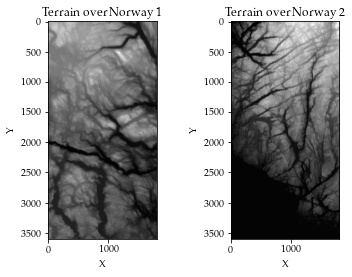

(3601, 1801)


In [3]:
# Load the terrain
terrain1_file = "SRTM_data_Norway_1.tif"
terrain2_file = "SRTM_data_Norway_2.tif"
terrain1 = imread(f'{INPUT_DATA}{terrain1_file}')
terrain2 = imread(f'{INPUT_DATA}{terrain2_file}')

# Plotting terrain
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.title.set_text("Terrain over Norway 1")
ax1.set_xlabel("X"); ax1.set_ylabel("Y")
surf1 = ax1.imshow(terrain1, cmap='gray')
ax2.title.set_text("Terrain over Norway 2")
ax2.set_xlabel("X"); ax2.set_ylabel("Y")
surf2 = ax2.imshow(terrain2, cmap='gray')
plt.savefig(f"{REPORT_FIGURES}{EX6}terrain_data.pdf")
plt.show()
print(terrain1.shape)

## Thoughts on the topographical data
Before we proceed with this exercise, we want to briefly discuss the nature of this terrain data compared to the generated frank function. We regard the franke function as generic because it is known and its behavior or shape can be generated for other values of x and y. Thus, creating a model that can generalize the function even with added noise for other unknown data points for x and y makes sense. However, we are uncertain if this idea of generalization is transferable to topographical terrain data in the same sense. The terrain data given is unique, and its shape cannot be generalized for unknown data points. If the purpose is to create the absolute best fit for the specific and unique terrain data, one could simply overfit to the terrain data by having an extremely high degree when fitting a model, and that is not really ML. One could probably argue that a model should tackle added noise on the terrain data and still be able to represent the shapes and contours incorporated in the image. However, images are what they are, and in this case, the topographical terrain "is what it is."  With that being said, we proceed with this exercise in the same spirit as done for exercises 1-5 even though we question this use case when working on this kind of real data.

# 3D plot of the whole Terrain image

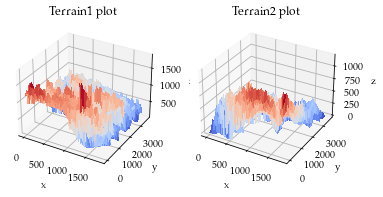

In [4]:
# Make data for terrain1
z1 = np.array(terrain1)
scaler = MinMaxScaler()
scaler.fit(z1)
z1_scaled = scaler.transform(z1)
#y1 = np.linspace(0,1,z1.shape[0])
#x1 = np.linspace(0,1,z1.shape[1])
y1 = np.arange(0, z1.shape[0])
x1 = np.arange(0, z1.shape[1])
x1_m, y1_m = np.meshgrid(x1,y1)

# Make data for terrain2
z2 = np.array(terrain2)
scaler = MinMaxScaler()
scaler.fit(z2)
z2_scaled = scaler.transform(z2)
#y2 = np.linspace(0,1,z2.shape[0])
#x2 = np.linspace(0,1,z2.shape[1])
y2 = np.arange(0, z2.shape[0])
x2 = np.arange(0, z2.shape[1])
x2_m, y2_m = np.meshgrid(x2,y2)

#%matplotlib
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1, projection='3d')
ax1.title.set_text("Terrain1 plot")
ax1.set_xlabel("x"); ax1.set_ylabel("y"); ax1.set_zlabel("z")
ax1.plot_surface(x1_m, y1_m, z1, cmap=cm.coolwarm, linewidth = 0, antialiased=False)

ax2 = fig.add_subplot(1,2,2, projection='3d')
ax2.title.set_text("Terrain2 plot")
ax2.set_xlabel("x"); ax2.set_ylabel("y"); ax2.set_zlabel("z")
ax2.plot_surface(x2_m, y2_m, z2, cmap=cm.coolwarm, linewidth = 0, antialiased=False)
plt.show()

# 6.0. Terrain data - Preprocessing and transformation
Least Square regression is not designed to tackle images directly. Thus, we must first transform the terrain data by slicing it into several bits and pieces. 

## 6.0.1 Resizeing the terrain image
For computational purpose, we resize the terrain image to have a resonable amount of datapoints for our least sqaure models.

720
360


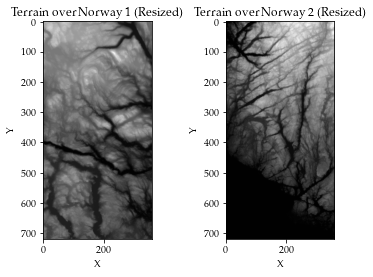

1161


In [5]:
ySize = int(terrain1.shape[0] * rescale_factor); print(ySize)
xSize = int(terrain1.shape[1] * rescale_factor); print(xSize)
terrain1Resized = cv2.resize(terrain1, (xSize, ySize))
terrain2Resized = cv2.resize(terrain2, (xSize, ySize))

# Plotting terrain
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.title.set_text("Terrain over Norway 1 (Resized)")
ax1.set_xlabel("X"); ax1.set_ylabel("Y")
surf1 = ax1.imshow(terrain1Resized, cmap='gray')
ax2.title.set_text("Terrain over Norway 2 (Resized)")
ax2.set_xlabel("X"); ax2.set_ylabel("Y")
surf2 = ax2.imshow(terrain2Resized, cmap='gray')
plt.savefig(f"{REPORT_FIGURES}{EX6}terrain_data_resized.pdf")
plt.show()
print(terrain1[0,0])

## 6.0.2 Creating image patches and Terrain data selection

## Methods

In [6]:
def create_img_patches(img, ySteps, xSteps):
    patches = []
    for y in range(0,img.shape[0], ySteps):
        for x in range(0,img.shape[1], xSteps):
            y_from = y; 
            y_to = y+ySteps; 
            x_from = x; 
            x_to = x+xSteps; 
            img_patch = img[y_from:y_to, x_from:x_to]        
            patches.append(img_patch)

    return patches

def patches_to_img(patches, ySteps, xSteps, nYpatches, nXpatches, plotImage=False):
    img = np.zeros((ySteps*nYpatches, xSteps*nXpatches))
    i = 0
    for y in range(0,img.shape[0], ySteps):
        for x in range(0,img.shape[1], xSteps):
            y_from = y; 
            y_to = y+ySteps; 
            x_from = x; 
            x_to = x+xSteps; 
            img[y_from:y_to, x_from:x_to] = patches[i]         
            i += 1
    
    if plotImage:
        plt.imshow(img, cmap='gray')
        plt.title("Reconstructed img")
        plt.show()
    return img

def plotTerrainPatches(patches, nYpatches, nXpatches, plotTitle="Terrain patches"):
    # Plotting terrain patches
    fig, ax = plt.subplots(nYpatches, nXpatches,figsize=(4,8))
    i=0
    for y in range(nYpatches):
        for x in range(nXpatches):
            ax[y,x].title.set_text(f"Patch{i}")
            ax[y,x].set_xlabel("X"); ax1.set_ylabel("Y")
            ax[y,x].imshow(patches[i], cmap='gray')
            i+=1
    
    fig.suptitle(f"{plotTitle}") # or plt.suptitle('Main title')
    plt.tight_layout()
    plt.savefig(f"{REPORT_FIGURES}{EX6}{plotTitle}.pdf")
    plt.show()

def createTerrainData(terrain, includeMeshgrid=True):
    z = np.array(terrain) 
    x = np.arange(0, z.shape[1])
    y = np.arange(0, z.shape[0])
    if includeMeshgrid:
        x, y = np.meshgrid(x,y)
    return x,y,z


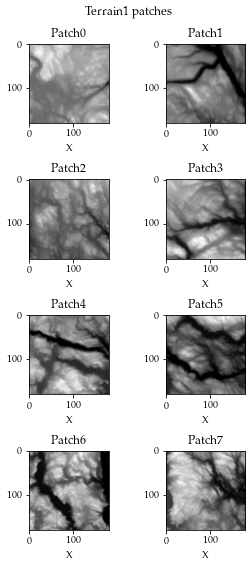

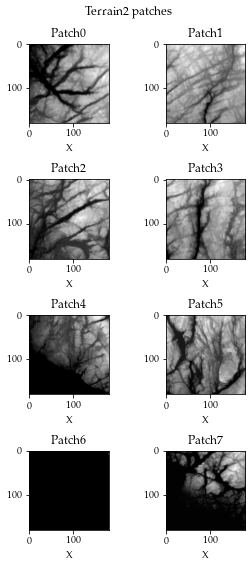

In [7]:
nXpatches = 2; nYpatches=4
ySteps = int(terrain2Resized.shape[0] / nYpatches)
xSteps = int(terrain2Resized.shape[1] / nXpatches)

patches_1 = create_img_patches(terrain1Resized, ySteps, xSteps)
plotTerrainPatches(patches_1, nYpatches, nXpatches, plotTitle="Terrain1 patches")

patches_2 = create_img_patches(terrain2Resized, ySteps, xSteps)
plotTerrainPatches(patches_2, nYpatches, nXpatches, plotTitle="Terrain2 patches")

# test
#img_reconstructed = patches_to_img(patches, ySteps, xSteps, nYpatches, nXpatches, plotImage=True)


## 6.0.3 Choosing of terrain patch and data creation
We look at the terrain data patches and choose which to create a fit for

In [8]:
img1 = patches_1[1]
img2 = patches_2[3]
x1, y1, z1 = createTerrainData(img1)
x2, y2, z2 = createTerrainData(img2)

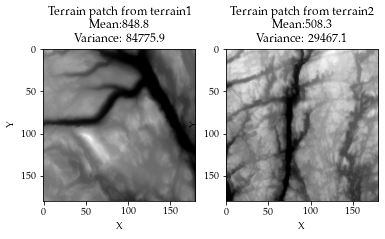

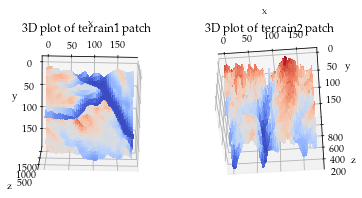

In [9]:
# 2D plot of the terrain patches
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.title.set_text(f"Terrain patch from terrain1\nMean:\
{np.round(np.mean(img1),decimals=1)}\nVariance: {np.round(np.var(img1),decimals=1)}")
ax1.set_xlabel("X"); ax1.set_ylabel("Y")
surf1 = ax1.imshow(img1, cmap='gray')

ax2.title.set_text(F"Terrain patch from terrain2\nMean:\
{np.round(np.mean(img2),decimals=1)}\nVariance: {np.round(np.var(img2),decimals=1)}")
ax2.set_xlabel("X"); ax2.set_ylabel("Y")
surf2 = ax2.imshow(img2, cmap='gray')
plt.savefig(f"{REPORT_FIGURES}{EX6}terrain_patch_to_fit_2D.pdf")
plt.show()

# 3D plot of the terrain patches
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1, projection='3d')
ax1.title.set_text(f"3D plot of terrain1 patch")
ax1.set_xlabel("x"); ax1.set_ylabel("y"); ax1.set_zlabel("z")
#ax1.view_init(elev=60., azim=-120.0-70)
#ax1.view_init(elev=-60., azim=-120.0+30)
ax1.view_init(elev=-75., azim=-91)
ax1.plot_surface(x1, y1, z1, cmap=cm.coolwarm, linewidth = 0, antialiased=False)

ax2 = fig.add_subplot(1,2,2, projection='3d')
ax2.title.set_text("3D plot of terrain2 patch")
ax2.set_xlabel("x"); ax2.set_ylabel("y"); ax2.set_zlabel("z")
#ax2.view_init(elev=60., azim=-120.0)
ax2.view_init(elev=-45., azim=-85.0)
ax2.plot_surface(x2, y2, z2, cmap=cm.coolwarm, linewidth = 0, antialiased=False)
plt.savefig(f"{REPORT_FIGURES}{EX6}terrain_patch_to_fit_3D.pdf")
plt.show()


## 6.0.4 Base input data for least square regression
We construct the data for least square regression based on preprocessed data. We also set up variables that will be used throughout the exercise.<br>
Terrain patch from terrain 1 is used as input for our models and our tests 

In [10]:
terrain_data = 1

if terrain_data == 1: # Choosing terrain1
    x, y, z = x1, y1, z1.copy() 
    #z_min = np.min(z)
    z_max = np.max(z)
    z = z1

elif terrain_data == 2: # Choosing terrain2
    x, y, z = x2, y2, z2.copy() 
    #z_min = np.min(z)
    z_max = np.max(z)
    z = z2

# 6.1 OLS on data (Exercise1)

## Running OLS fit on the data as done in EX1 
Note that we exlude the calculation of CL for betas, since it is emedded within the model itself. See common.py for that code

In [17]:
degrees = 6
z_flat = z.ravel(); z_flat = z_flat.reshape(-1,1)
z_train_OLS = pd.DataFrame()
z_hat_train_OLS = pd.DataFrame()
z_test_OLS = pd.DataFrame()
z_hat_test_OLS = pd.DataFrame()

df = pd.DataFrame()
for degree in range(1, degrees+1):
    print(f"Running OLS fitting on degree{degree}")
    X = create_X(x, y, degree) # Design Matrix
    
    # Scaling data and splitting it into training and test sets
    #X_train, X_test, z_train, z_test = prepare_data(X, z, test_size=0.2, shuffle=True, scale_X=False, scale_t=False)
    X_train, X_test, z_train, z_test = prepare_data(X, z_flat, test_size=0.2, shuffle=True, scale_X=True, scale_t=True, random_state=SEED_VALUE)
    
    # Model construction, fitting, and predictions
    model = OLS(degree=degree) # The model
    z_hat_train = model.fit(X_train, z_train, SVDfit=False) # Fitting the model and predict on training data
    z_hat_test = model.predict(X_test) # predict on test data
    
    # Evaluatation metrics
    MSE_score_train = MSE(z_train, z_hat_train)
    R2_score_train = R2(z_train, z_hat_train)
    MSE_score_test = MSE(z_test, z_hat_test)
    R2_score_test = R2(z_test, z_hat_test)
            
    # Filling up dataframes for train and test evaluation
    summary_df = model.summary()
    df = pd.concat([df,summary_df], axis=0)

    z_train_OLS[degree] = z_train.flatten() 
    z_hat_train_OLS[degree] = z_hat_train.flatten()
    z_test_OLS[degree] = z_test.flatten()
    z_hat_test_OLS[degree] = z_hat_test.flatten()

    # Storing data for all degrees
    results = {"X_train":X_train, "X_test":X_test,"z_train":z_train, "z_test":z_test,
               "z_hat_train":z_hat_train, "z_hat_test":z_hat_test, "model":model, "summary":summary_df}
    #OLSrun.append(results)


# MSE calculations for all degrees
mse_scores_train = ((z_train_OLS - z_hat_train_OLS) ** 2).mean()
mse_scores_test = ((z_test_OLS - z_hat_test_OLS) ** 2).mean()
# R2 calculations for all degrees
R2_scores_train = 1 - ((z_train_OLS - z_hat_train_OLS) ** 2).sum() / ((z_train_OLS - z_train_OLS.mean())**2).sum() 
R2_scores_test = 1 - ((z_test_OLS - z_hat_test_OLS) ** 2).sum() / ((z_test_OLS - z_test_OLS.mean())**2).sum()

Running OLS fitting on degree1
Running OLS fitting on degree2
Running OLS fitting on degree3
Running OLS fitting on degree4
Running OLS fitting on degree5
Running OLS fitting on degree6


c:\Users\andre\Dropbox\FYS-STK4155_projects\FYS-STK4155 - Project1\FYS-STK4155-Prj1_report\code\common.py:79: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var_hat * invXTX_diag)


## Plotting performance of OLS for different degrees

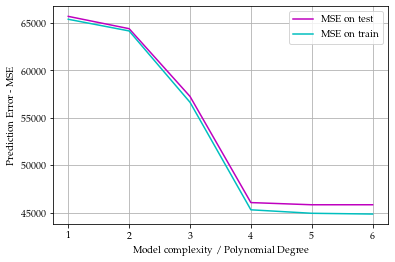

In [12]:
plt.plot(np.arange(1,degrees+1), mse_scores_test,"m", label='MSE on test')
plt.plot(np.arange(1,degrees+1), mse_scores_train,"c", label='MSE on train')
#plt.plot(np.arange(1,degrees+1), R2_scores_test, label='R2 on test')
#plt.plot(np.arange(1,degrees+1), R2_scores_train, label='R2 on train')
plt.xlabel("Model complexity / Polynomial Degree")
plt.ylabel("Prediction Error - MSE")
plt.xticks(np.arange(1,degrees+1))
plt.grid(True)
plt.legend()
plt.savefig(f"{REPORT_FIGURES}{EX6_1}terrain_patch_OLS_evaluate_fit.pdf")
plt.show()

## Looking at $\beta$ values

df_degree.shape: (15, 6)


,degree,coeff name,coeff value,std error,CI lower,CI upper
0,4.0,$\beta$0,-0.0,0.0,-0.0,0.0
1,4.0,$\beta$1,-0.0026,0.0001,-0.0027,-0.0025
2,4.0,$\beta$2,0.0004,0.0001,0.0003,0.0005
3,4.0,$\beta$3,-0.2825,0.005,-0.2922,-0.2727
4,4.0,$\beta$4,0.288,0.0067,0.2748,0.3011
5,4.0,$\beta$5,-0.133,0.005,-0.1427,-0.1233
6,4.0,$\beta$6,0.0024,0.0001,0.0023,0.0025
7,4.0,$\beta$7,-0.0008,0.0001,-0.0009,-0.0007
8,4.0,$\beta$8,-0.0013,0.0001,-0.0015,-0.0012
9,4.0,$\beta$9,0.0014,0.0001,0.0013,0.0015


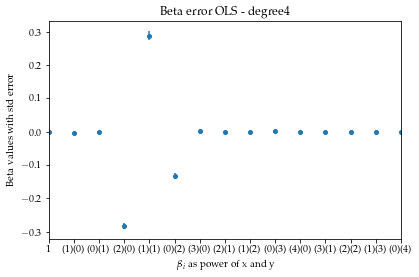

In [18]:
optimal_degree = 4
df_degree = df[df["degree"] == optimal_degree]
print("df_degree.shape:",df_degree.shape)
display(df_degree)
df_degree.to_csv(f"{REPORT_DATA}{EX6_1}OLS_beta_error_degree{optimal_degree}.csv")

fig = plot_beta_errors(df_degree, optimal_degree)
fig.savefig(f"{REPORT_FIGURES}{EX6_1}OLS_beta_error_degree{optimal_degree}.pdf")


## Plotting the fitted terrain image using the most optimal degree

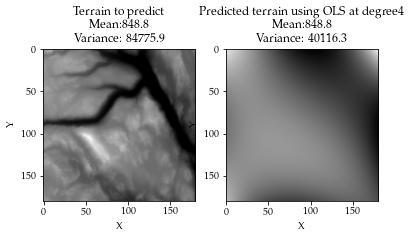

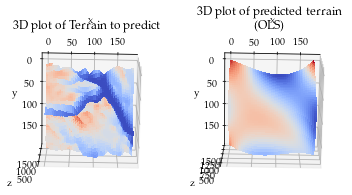

In [19]:
X = create_X(x1, y1, optimal_degree) # Design Matrix
X_scaled, _ = standard_scaling_single(X)
z1_scaled, z1_scaler = standard_scaling_single(z.ravel().reshape(-1,1))

# Model construction, fitting, and predictions
model = OLS(degree=optimal_degree) # The model
z_hat_train = model.fit(X_scaled, z1_scaled, SVDfit=False, keep_intercept=True) # Fitting the model and predict on training data

z_hat = z1_scaler.inverse_transform(z_hat_train)
z_hat = z_hat.reshape((ySteps,xSteps))

# 2D plot of the terrain patches
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.title.set_text(F"Terrain to predict\nMean:\
{np.round(np.mean(z),decimals=1)}\nVariance: {np.round(np.var(z),decimals=1)}")
ax1.set_xlabel("X"); ax1.set_ylabel("Y")
surf1 = ax1.imshow(z, cmap='gray')

ax2.title.set_text(F"Predicted terrain using OLS at degree{optimal_degree}\nMean:\
{np.round(np.mean(z_hat),decimals=1)}\nVariance: {np.round(np.var(z_hat),decimals=1)}")
ax2.set_xlabel("X"); ax2.set_ylabel("Y")
surf2 = ax2.imshow(z_hat, cmap='gray')
plt.savefig(f"{REPORT_FIGURES}{EX6_1}chosen_terrain_data_and_prediction_at_degree{optimal_degree}.pdf")
plt.show()

# 3D plot of predicted terrain patches
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1, projection='3d')
ax1.title.set_text("3D plot of Terrain to predict")
ax1.set_xlabel("x"); ax1.set_ylabel("y"); ax1.set_zlabel("z")
#ax1.view_init(elev=60., azim=-120.0-70)
ax1.view_init(elev=-75., azim=-91)
ax1.plot_surface(x1, y1, z1, cmap=cm.coolwarm, linewidth = 0, antialiased=False)

ax2 = fig.add_subplot(1,2,2, projection='3d')
ax2.title.set_text("3D plot of predicted terrain\n(OLS)")
ax2.set_xlabel("x"); ax2.set_ylabel("y"); ax2.set_zlabel("z")
#ax2.view_init(elev=60., azim=-120.0-70)
ax2.view_init(elev=-75., azim=-91)
ax2.plot_surface(x1, y1, z_hat, cmap=cm.coolwarm, linewidth = 0, antialiased=False)
plt.savefig(f"{REPORT_FIGURES}{EX6_1}chosen_terrain_data_and_prediction_at_degree{optimal_degree}_3D.pdf")
plt.show()

### Comments on the OLS fit to terrain data:
We scale the data since x, y, z is they are not between 0 to 1. Degree of 4 seems to yeild the best performance when fitting to the choosen terrain data.

## Trying to overfit to terrain for all patches

100%|██████████| 8/8 [00:00<00:00, 533.17it/s]


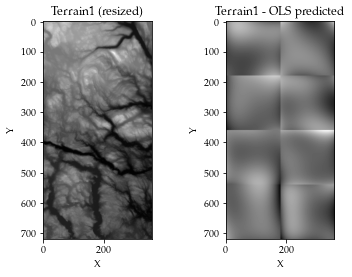

In [20]:
testDegree = 150
testDegree = 4
patches_1_preds = []
X = create_X(x1, y1, testDegree) # Design Matrix
X_scaled, _ = standard_scaling_single(X)

for patch in tqdm(patches_1):
    z_scaled, _ = standard_scaling_single(patch.ravel().reshape(-1,1))
    model = OLS(degree=testDegree) # The model
    z_hat_train = model.fit(X_scaled, z_scaled, SVDfit=False, keep_intercept=True) # Fitting the model and predict on training data
    z_hat = z_hat_train.reshape((ySteps,xSteps))
    patches_1_preds.append(z_hat)
    
terrain1_predicted = patches_to_img(patches_1_preds, ySteps, xSteps, nYpatches, nXpatches, plotImage=False)

# Plotting predicted patches
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.title.set_text(f"Terrain1 (resized)")
ax1.set_xlabel("X"); ax1.set_ylabel("Y")
surf1 = ax1.imshow(terrain1Resized, cmap='gray')
ax2.title.set_text(f"Terrain1 - OLS predicted")
ax2.set_xlabel("X"); ax2.set_ylabel("Y")
surf2 = ax2.imshow(terrain1_predicted, cmap='gray')
plt.savefig(f"{REPORT_FIGURES}{EX6_1}terrain_and_all_patches_predicted_at_degree{testDegree}.pdf")
plt.show()

# TODO:
#### This text may have to be adjusted
A degree of 4 or 5 seems to give a smooth surface for all the predicted patches. We find that the distortion and noise increase in the predicted image when the degree increases above 4-5 considering all patches. At higher degrees, some artifacts within the predicted patches also appear. In the predicted image with all patches, one can see some of the contours of the topographic structures in the image we try to approximate. However, the predicted image that is reconstructed from all the predicted patches is not very accurate. The task of this kind of problem is too complex for an OLS to manage. It may be that having smaller patches would increase the accuracy in reproducing the details incorporated in the input image. 

# 6.2 Bias-variance trade-off and resampling techniques on terrain data (Exercise2)

## 6.2.1 Setting up variables and data

In [ ]:
np.random.seed(SEED_VALUE)
maxdegree = 10
n_bootstraps = 10
MSE_test = np.zeros(maxdegree)
MSE_train = np.zeros(maxdegree)
polydegree = np.arange(1,maxdegree+1)
bias = np.zeros(maxdegree)
variance = np.zeros(maxdegree)
z_flat = z.ravel().reshape(-1,1); 
z_flat = z_flat.reshape(-1,1)

## 6.2.2 Testing out different degrees while resampling using bootstrap

In [ ]:
for degree in tqdm(range(1, maxdegree+1), desc = f"Looping through polynomials up to {maxdegree} degrees with {n_bootstraps} bootstraps: "):
    #model= make_pipeline(PolynomialFeatures(degree=degree), LinearRegression(fit_intercept=False)) 
    X = create_X(x, y, n=degree)

    # Train test split
    X_train, X_test, z_train, z_test = prepare_data(X, z_flat, test_size=0.2, shuffle=True, scale_X=True, scale_t=True, random_state=SEED_VALUE)

    #TODO: why scale?!?
    # How do we scale? should test and train have different scalers or use the same?
    # Scaling
    
    model =  OLS(degree=degree)
    z_hat_trains, z_hat_tests = bootstrapping(X_train, z_train, X_test, z_test, 
                                              n_bootstraps, model, keep_intercept=True)
      
    MSE_test[degree-1] = np.mean( np.mean((z_test - z_hat_tests)**2, axis=1, keepdims=True ))
    MSE_train[degree-1] = np.mean( np.mean((z_train - z_hat_trains)**2, axis=1, keepdims=True ))
    bias[degree-1] = np.mean( (z_test - np.mean(z_hat_tests, axis=1, keepdims=True))**2 )
    variance[degree-1] = np.mean( np.var(z_hat_tests, axis=1, keepdims=True))
       
plt.plot(polydegree, MSE_test,"m", label='MSE test')
plt.plot(polydegree, MSE_train,"c", label='MSE train')
plt.plot(polydegree, bias,"b--", label='bias')
plt.plot(polydegree, variance,"r--", label='Variance')
#plt.plot(polydegree, bias+variance,"g--", label='bias+variance')

plt.xlabel("Model complexity / Polynomial Degree")
plt.ylabel("Prediction Error - MSE")
plt.xticks(polydegree)
plt.grid(True)
plt.legend()
plt.savefig(f"{REPORT_FIGURES}{EX6_2}model_complexity_using_bootstrap.pdf")
plt.show()

# 6.3 Cross-validation as resampling techniques, adding more complexity (Exercise3)

## 6.3.1 Cross validation algorithm

In [ ]:
"""
np.random.seed(SEED_VALUE)
def cross_val(X_data:np.ndarray, t_data:np.ndarray, model: object, k_folds_from = 5,k_folds_to = 11)-> Tuple[list, list]:
    t_data = t_data.ravel()
    t_data = np.expand_dims(t_data, axis=1)
    numb_of_its = k_folds_to-k_folds_from
    mean_MSE_test = np.zeros(numb_of_its)
    mean_MSE_train = np.zeros(numb_of_its)
    
    inds = np.arange(t_data.shape[0])
    #shuffle indicies to create random folds: 
    np.random.shuffle(inds)
    
    #create array for plotting:
    folds = np.zeros(numb_of_its)
    for fold in range(k_folds_from,k_folds_to):
        #split inds into multiple sub-arrays of equal or aprox equal size: 
        fold_inds = np.array_split(inds, fold)
        MSE_test = np.zeros(fold)
        MSE_train = np.zeros(fold)
        folds[fold-k_folds_from] = fold 
        for k in range(fold):
            #get array elements at indx k from folds_inds and use as test data: 
            X_test = X_data[fold_inds[k],:]
            z_test = t_data[fold_inds[k]]
    
            #create training data by removing test-indicies from data
            X_train = np.delete(arr = X_data, obj = fold_inds[k],axis = 0)
            z_train = np.delete(t_data, fold_inds[k]) 
            z_train = np.expand_dims(z_train, axis=1)
      
            # Scale data: 
            X_train, _ = standard_scaling(X_train)
            z_train, _ = standard_scaling(z_train)
            X_test, _ = standard_scaling(X_test)
            z_test, _ = standard_scaling(z_test)
            
            #fit model and predict on train data:
            z_hat_train = model.fit(X_train, z_train, SVDfit=False)
            
            #predict on test data:
            z_hat_test = model.predict(X_test)
            
            # Storing MSE values
            MSE_test[k] = np.mean((z_test - z_hat_test)**2)
            MSE_train[k] = np.mean((z_train - z_hat_train)**2) 
            
        mean_MSE_test[fold-k_folds_to] = np.mean(MSE_test)
        mean_MSE_train[fold-k_folds_to] = np.mean(MSE_train)
        
    return mean_MSE_test,mean_MSE_train, folds
"""

## 6.3.2 Setting up variables and data

In [ ]:
z_flat = z.ravel().reshape(-1,1); 
z_flat = z_flat.reshape(-1,1)

## 6.3.3 Testing out different degrees

In [ ]:
degree = 10
mean_folds_error = np.zeros(6)

for folds in range(5,11):
    sk_model = sk.LinearRegression()
    sk_scores = cross_val_score(sk_model, X, z_flat, cv=folds, scoring = "neg_mean_squared_error")
    
    implemented_scores = cross_val(k = folds, model = "OLS", X = X, z = z_flat, shuffle=True)
    #plt.plot(np.arange(folds), score,"-o", label = f"{folds} folds")
    plt.plot(np.arange(folds), sk_scores*-1,"--o", label = f"{folds} folds(sk.cv)")
    plt.xlabel("fold used as test data")
    plt.ylabel("MSE")
    plt.legend()
    mean_folds_error[folds-5] = np.mean(implemented_scores)
    #print(sk_scores)
    #print(implemented_scores)

In [ ]:
plt.plot(np.arange(5,11), mean_folds_error)
plt.xlabel("Number of folds")
plt.ylabel("MSE")
plt.show()

In [ ]:
"""
maxdegree = 5
for degree in range(1, maxdegree+1):
    X = create_X(x, y, n=degree)  
    MSE_test, MSE_train, folds = cross_val(X_data= X, t_data=z, model=OLS(degree))
    plt.plot(folds, MSE_test,"m", label='MSE test')
    plt.plot(folds, MSE_train,"c", label='MSE train')

    plt.xlabel(f"Folds at polynomial degree:{degree}")
    plt.ylabel("Prediction Error - MSE")

    plt.grid(True)
    plt.legend()
    plt.savefig(f"{REPORT_FIGURES}{EX6_3}model_complexity_using_CV_degree{degree}.pdf")
    plt.show()
"""

# 6.4 Ridge Regression on the Franke function with resampling (Exercise4)

## 6.4.1 Setting up variables and data

In [ ]:
nbf_lambdas = 10
lambdas = np.logspace(-5,5, nbf_lambdas)
z_train_ridge = pd.DataFrame()
z_hat_train_ridge = pd.DataFrame()
z_test_ridge = pd.DataFrame()
z_hat_test_ridge = pd.DataFrame()
z_hat_train_ridge_sk = pd.DataFrame()
z_hat_test_ridge_sk = pd.DataFrame()

## 6.4.2 Ridge regression - finding optimal lambda without resampling

In [ ]:
for lmb in lambdas:
    #X_train, X_test, z_train, z_test = prepare_data(X, z, test_size=0.2, shuffle=True, scale_X=False, scale_t=False)
    X_train, X_test, z_train, z_test = prepare_data(X, z_flat, test_size=0.2, shuffle=True, 
                                                    zero_center = False, scale_X=True, scale_t=True, 
                                                    random_state=SEED_VALUE)
    
    """
    print(f"X_train.shape:{X_train.shape}")
    print(f"z_train.shape:{z_train.shape}")
    print(f"X_test.shape:{X_test.shape}")
    print(f"z_test.shape:{z_test.shape}")
    """
    # Fitting the scikit Ridge model
    model_sk = lm.Ridge(lmb, fit_intercept=True)
    model_sk.fit(X_train, z_train)
    
    # Predictions sklearn Ridge
    z_hat_train_sk = model_sk.predict(X_train) # predict on train data
    z_hat_test_sk = model_sk.predict(X_test) # predict on test data
    
    # Fitting our Ridge model and predicting on training data
    model = RidgeRegression(lmb) # The model
    z_hat_train = model.fit(X_train, z_train, SVDfit=False, keep_intercept=False) # Fitting the model    
    z_hat_test = model.predict(X_test) # predict on test data

    # Filling up sk dataframes
    z_hat_train_ridge_sk[lmb] = z_hat_train_sk.flatten()
    z_hat_test_ridge_sk[lmb] = z_hat_test_sk.flatten()
    
    # Filling up dataframes
    z_train_ridge[lmb] = z_train.flatten() 
    z_hat_train_ridge[lmb] = z_hat_train.flatten()
    z_test_ridge[lmb] = z_test.flatten()
    z_hat_test_ridge[lmb] = z_hat_test.flatten()

# MSE calculations for all lambda values
mse_scores_train = ((z_train_ridge - z_hat_train_ridge) ** 2).mean()
mse_scores_test = ((z_test_ridge - z_hat_test_ridge) ** 2).mean()
mse_scors_train_sk = ((z_train_ridge - z_hat_train_ridge_sk) ** 2).mean()
mse_scores_test_sk = ((z_test_ridge - z_hat_test_ridge_sk) ** 2).mean()

# R2 calculations for all lambda values
R2_scores_train = 1 - ((z_train_ridge - z_hat_train_ridge) ** 2).sum() / ((z_train_ridge - z_train_ridge.mean())**2).sum() 
R2_scores_test = 1 - ((z_test_ridge - z_hat_test_ridge) ** 2).sum() / ((z_test_ridge - z_test_ridge.mean())**2).sum()  

# Plots
plt.figure(figsize=(8,7))
plt.plot(-np.log(lambdas), mse_scores_train, label="Training data")
plt.plot(-np.log(lambdas), mse_scores_test, label="Test data")

plt.plot(-np.log(lambdas), mse_scors_train_sk, 'm--', label="Training data sklearn")
plt.plot(-np.log(lambdas), mse_scores_test_sk, 'y--', label="Test data sklearn")

#plt.plot(mse_scores_train,-np.log(lambdas), label="Training data")
#plt.plot(mse_scores_test,-np.log(lambdas), label="Test data")
plt.xlabel("log(lambda)")
plt.ylabel("MSE")
plt.title("Training evaluation on Ridge regression fit")
plt.legend()
plt.savefig(f"{REPORT_FIGURES}{EX6_4}Ridge_finding_optimal_lambda_without_resampling.pdf")
plt.show()

## 6.4.3 Ridge regression - finding optimal lambda using bootstrap

In [ ]:
n_bootstraps = 100
maxdegree = 12

#lambdas = [-5,4]
i = 0
for lmb in lambdas:
    MSE_test = np.zeros(maxdegree)
    MSE_train = np.zeros(maxdegree)
    polydegree = np.arange(maxdegree)
    bias = np.zeros(maxdegree)
    variance = np.zeros(maxdegree)

    for degree in tqdm(range(maxdegree), desc = f"Looping through polynomials up to {maxdegree} degrees with {n_bootstraps} bootstraps: "):
        #model= make_pipeline(PolynomialFeatures(degree=degree), LinearRegression(fit_intercept=False)) 
        X = create_X(x, y, n=degree)

        # Train test split
        X_train, X_test, z_train, z_test = prepare_data(X, z_flat, test_size=0.2, shuffle=True, scale_X=True, scale_t=True, random_state=SEED_VALUE)

        #TODO: why scale?!?
        # How do we scale? should test and train have different scalers or use the same?
        # Scaling

        model =  RidgeRegression(lambda_val=lmb)
        z_hat_trains, z_hat_tests = bootstrapping(X_train, z_train, X_test, z_test, 
                                                  n_bootstraps, model, keep_intercept=False)
            
        MSE_test[degree] = np.mean( np.mean((z_test - z_hat_tests)**2, axis=1, keepdims=True ))
        MSE_train[degree] = np.mean( np.mean((z_train - z_hat_trains)**2, axis=1, keepdims=True ))
        bias[degree] = np.mean( (z_test - np.mean(z_hat_tests, axis=1, keepdims=True))**2 )
        variance[degree] = np.mean( np.var(z_hat_tests, axis=1, keepdims=True))

    plt.figure()
    plt.plot(polydegree, MSE_test,"m", label='MSE test')
    plt.plot(polydegree, MSE_train,"c", label='MSE train')

    plt.plot(polydegree, bias,"g--", label='bias')
    plt.plot(polydegree, variance,"r--", label='Variance')

    plt.title(f"Bias-Variance for lambda:{lmb}")
    plt.xlabel("Model complexity / Polynomial Degree")
    plt.ylabel("Prediction Error")

    plt.grid(True)
    plt.legend()
    plt.savefig(f"{REPORT_FIGURES}{EX6_4}Ridge_finding_optimal_lambda_using_bootstrap_lambda_num{i}.pdf")
    plt.show()

    summary_df, _ = model.summary()
    CI_lower_betas = summary_df["CI lower"]
    CI_upper_betas = summary_df["CI upper"]
    betas = summary_df["coeff value"]
    i+=1

    #display(model.summary())
      

## Ploting beta error for different lambda values for the most optimal degree

In [ ]:
optimal_degree = 4
min_lambda = -4 
max_lambda = 4 
nbf_lambdas = 20
lambdas = np.logspace(min_lambda,max_lambda, nbf_lambdas)
summaries_df = pd.DataFrame()

for lmb in lambdas:
    #MSE_test = np.zeros(maxdegree)
    #MSE_train = np.zeros(maxdegree)
    #polydegree = np.arange(maxdegree)
    #bias = np.zeros(maxdegree)
    #variance = np.zeros(maxdegree)

    X = create_X(x, y, n=optimal_degree)
    X_train, X_test, z_train, z_test = prepare_data(X, z_flat, test_size=0.2, shuffle=True, scale_X=True, scale_t=True, random_state=SEED_VALUE)
    model =  RidgeRegression(lambda_val=lmb)
    z_hat_train = model.fit(X_train, z_train, SVDfit=False, keep_intercept=False)        
    summary_df = model.summary()
    summaries_df = pd.concat([summaries_df,summary_df], axis=0)
    
fig = plot_beta_errors_for_lambdas(summaries_df, optimal_degree)
fig.savefig(f"{REPORT_FIGURES}{EX6_4}Ridge_beta_SE_for_lambdas.pdf")

fig = plot_beta_CI_for_lambdas(summaries_df, optimal_degree)
fig.savefig(f"{REPORT_FIGURES}{EX6_4}Ridge_beta_CI_for_lambdas.pdf")

## 6.4.4 Ridge regression - finding optimal lambda using cross-validation

## 6.4.5 Ridge regression - bias-variance trade-off using bootstrap

# 6.5. Lasso Regression on the Franke function with resampling (Exercise5)

## 6.5.1 Lasso

# Tests of dimensions image reduction and patches

In [ ]:
i = 1
value = 720
while True:
    i += 1
    if((value % i)==0):
        print(f"value:{value / i} at i:{i}")
    if(i>=value):
        break

In [ ]:
i = 1
value = 360
while True:
    i += 1
    if((value % i)==0):
        print(f"value:{value / i} at i:{i}")
    if(i>=value):
        break